# HQCS Assignment 3 – Task 4: Quantum Circuit Compilation

**Group:** 10  

**Members:** Marijana Petojevic, Vedad Hadzic, Sam de Vries

**Environment:** Google Colab T4 GPU


# Introduction

In this notebook, the working of quantum circuit compilation is analysed. This is done using the Bernstein-Vazirani (BV) circuit.

The goal is to look at how quantum circuit compilation works, and to investigate the workings of different level of optimization levels.

## Install dependencies and libraries

In [1]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install pylatexenc
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=05fc883f920219fb9bbee2de47202b6a74df2127b0bd90fad2e6921c6e91f9c3
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeCasablancaV2
from qiskit import transpile
from qiskit import *
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator


## Variables

This code block contains all the variables that can be used to alter the working of the transpilation process.

In [3]:
# Set desire for noise free
noise_free = False # if 'True' -> AerSimulator
optimization_level = 3 # only if 'noise-free' == False

# Set bitstring
s = '10101'
nodes = len(s)

## Circuit

The BV circuit is denoted below.

This is followed by a print of the circuit as we feed it into the computer.

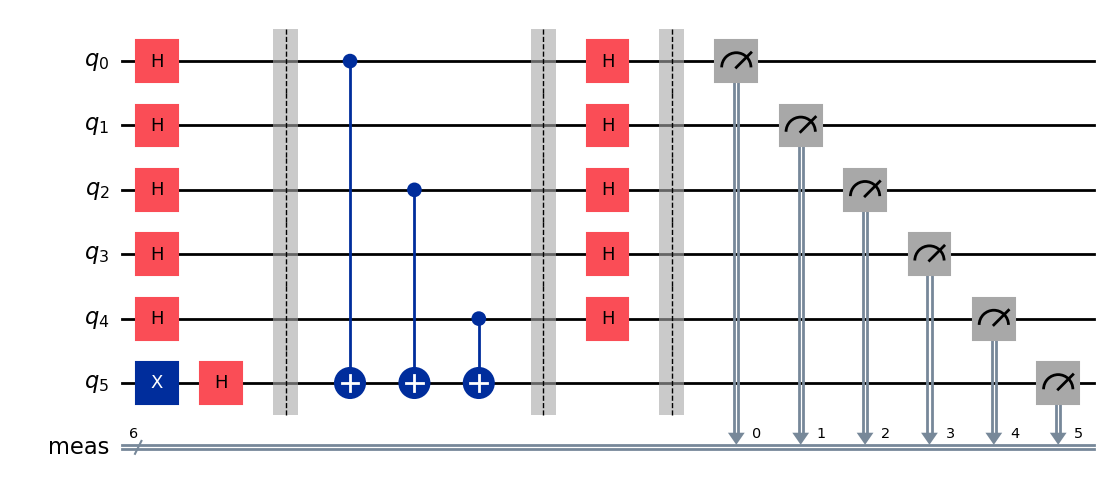

In [4]:
# Circuit for the Bernstein-Vazirani algorithm
circuit = QuantumCircuit(nodes+1)

# Set up the ancilla
circuit.x(nodes)
circuit.h(nodes)

# Apply Hadamard gate on qubits
for i in range(nodes):
    circuit.h(i)

circuit.barrier() # For a pretty print

for i,bit in enumerate(s): # The oracle part
    if bit =='1':
        circuit.cx(i, nodes)

circuit.barrier() # For a pretty print

# Apply second Hadamrd gate on qubits
for i in range(nodes):
    circuit.h(i)

circuit.measure_all()
circuit.draw('mpl', style="iqp")

# Transpilation

Transpilation is the process of converting an input circuit to a circuit that can actually be used by the systems hardware.

We have two versions of transpilation:
- AerSimulation -> This backend is noise less, and there fore deterministic
- FakeCasaBlancaV2 -> This backend contains noise.

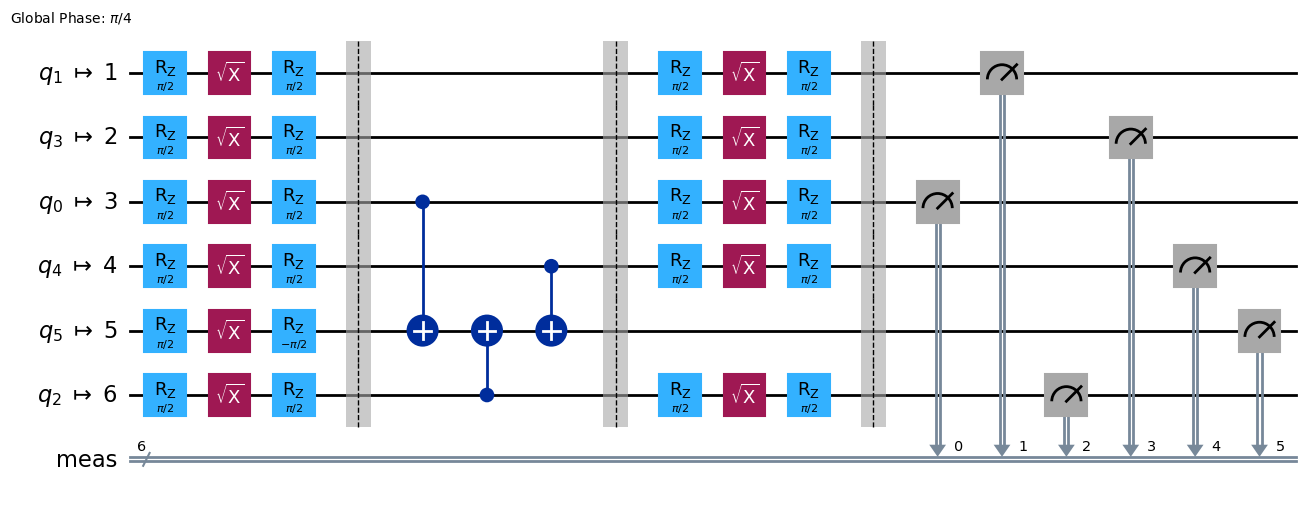

In [5]:
if noise_free: # Method using AerSimulator
    backend = AerSimulator()
    transpiled_circuit = transpile(circuit, backend,
                                   optimization_level=optimization_level)


else: # Method using FakeCasablance (Noise)
    # Chosen because we needed at least 6 qubits in the backend (has 7 qubits)
    backend = FakeCasablancaV2()
    transpiled_circuit = transpile(circuit, backend,
                                   optimization_level=optimization_level)

# Sample from the circuit
sampler = SamplerV2(backend)
job = sampler.run([transpiled_circuit])
pub_result = job.result()[0]
counts = pub_result.data.meas.get_counts()
transpiled_circuit.draw('mpl', style="iqp")

# Visualisation

This code block shows the outcome of each backend configuration.

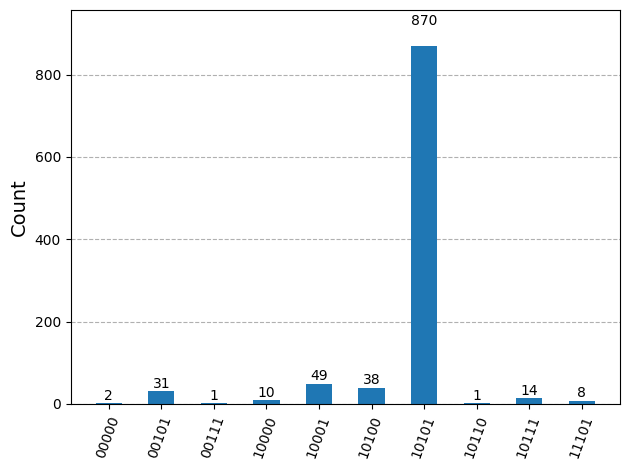

In [6]:
correct_counts = {}
# Change the string into the correct form
for bitstring, prob in counts.items():
    # reverse the string and remove the ancilla
    corrected = bitstring[::-1][:nodes]
    if corrected in correct_counts:
        correct_counts[corrected] += prob
    else:
        correct_counts[corrected] = prob

plot_histogram(correct_counts)



# Optimization level comparison

Now we will compare the circuit for a transpilation with optimization level 0 (OL0) and optimization level 3 (OL3).

OL0

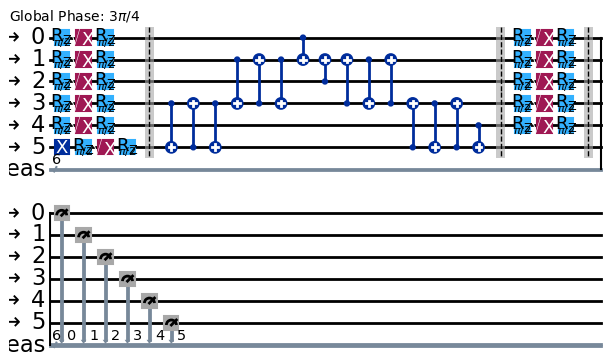

OL3

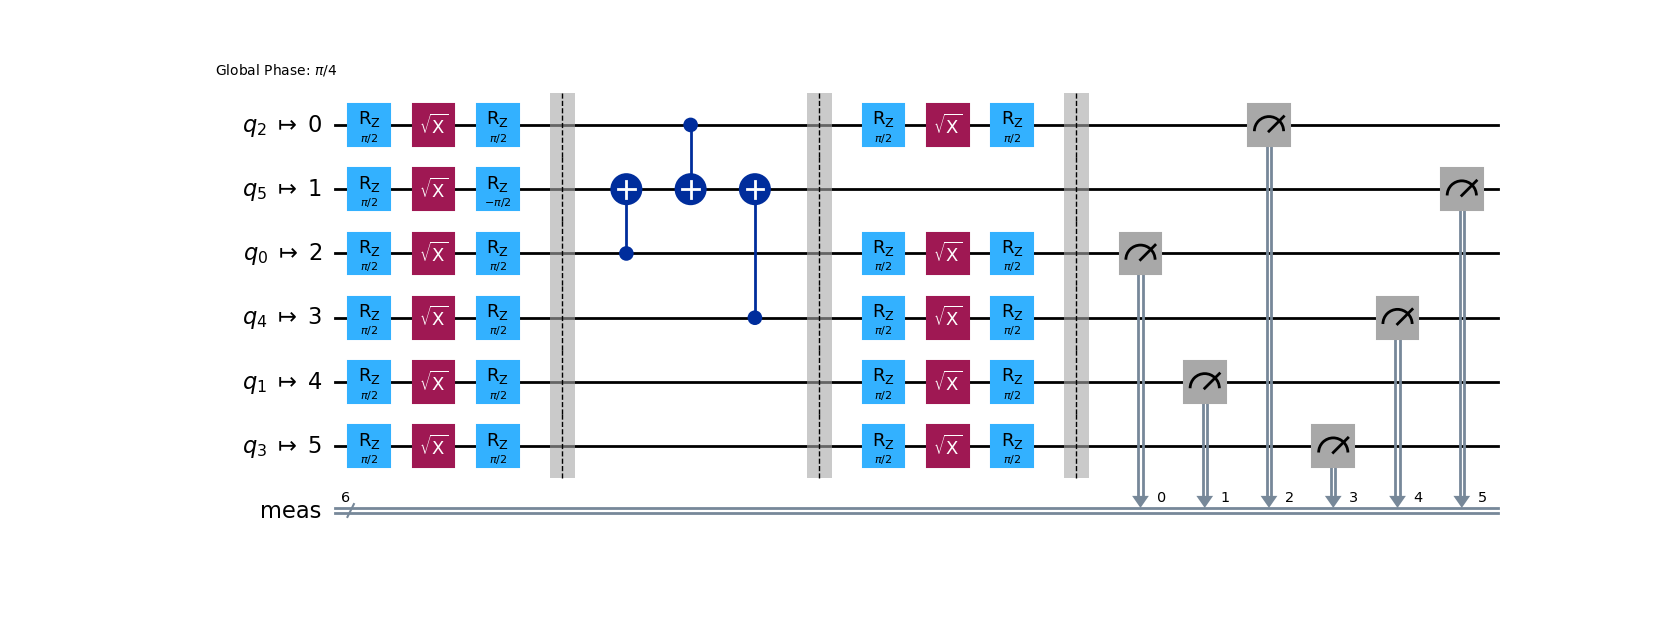

Comparison

When comparing the circuits of OL0 and OL3, we can immediately notice that the Hadamard gate is not included in the universal set of gates. The Hadamard gate is rewritten into other gates that are supported by the backend. In both optimization levels the Hadamard gate is exchanged for the same set of gates.

Another interesting observation is in the part of the oracle. The pre-transpilation circuit has only 3 CNOT gates, while the transpilation circuit with OL0 has 15 CNOT gates. This can be explained using the concept of a coupling graph. A coupling graph shows which qubits on a quantum device can directly interact. Looking at OL0, we can reason that the max distance in the coupling graph is 2. Meaning that CNOT(q1,q3) is possible while CNOT(q1, q4) is not. In the original circuit (without transpilation), we can see that CNOT(q0,q5) and CNOT(q2,q5) both need to be rewritten. These gates can be rewritten into a sequence of CNOTs that do not exceed the maximum distance. Resulting in a higher count of CNOT gates for OL0 but not for OL3.

OL3 swaps the qubits to make sure that no CNOT will have a distance exceeding 2. OL3 does this by remapping logical qubits to different physical qubits.

# Questions

This exercise contained multiple questions these willl moslty be explained in this notebook.

*Suppose a two-qubit device supports a CNOT gate on qubits 1 and 2 in only one
direction. For example, CNOT(q1, q2) is allowed, but CNOT(q2, q1) is not. Describe
how to compile the CNOT(q2, q1) instruction on this device. No coding needed.*


We found a way of rewriting the CNOT gate by using two Hadamard gates with a CZ gate in between. We used the intuition that the CNOT gate, which is the controlled-X gate, in the Z-basis causes the bits to "flip". Therefore, the "inverse" should yield the same outcome. With the "inverse" we mean using the controlled-Z gate in the X-basis. In formula form this gives:

$$
X = H Z H
$$

$$
Z = H X H
$$

$$
\text{CNOT}_{c,t} = (I_c \otimes H_t)\text{CZ}_{c,t}(I_c \otimes H_t)
$$

$$
\text{CZ}_{c,t} = (I_c \otimes H_t)\text{CNOT}_{c,t}(I_c \otimes H_t)
$$

Using this information, we can rewrite $\text{CNOT}(q_2, q_1)$ as:

$$
\text{CNOT}_{q_2,q_1} = (I_{q_2} \otimes H_{q_1})\text{CZ}_{q_2,q_1}(I_{q_2} \otimes H_{q_1})
$$

It is worth mentioning that the CNOT gate can be rewritten in more ways, given that the Hadamard and CZ gates can also be rewritten. However, this seemed the easiest way in terms of the amount of gates and intuition.


*Suppose we have a three-qubit device with a linear coupling graph, and suppose that
we allow CNOT operations between qubits q1 and q2, as well as between qubits q2
and q3. Implement a CNOT between q1 and q3 without changing the mapping. No
coding needed.*

We need to solve the problem of implementing CNOT(q1,q3) with a linear coupling graph. By rewriting this into another form, we get the following desired outcome:

$
|a, b, c \oplus a\rangle
$

Now, we start by using q2 as a way of carrying information of q1 to q3. This can be realised by starting with CNOT(q1, q2), resulting in the following change:
$
| a, b, c\rangle \rightarrow |a, b \oplus a, c\rangle
$

Now we can transfer the information of q1, that is stored in q2, to q3. CNOT(q2,q3) gives:

$
|a, b \oplus a, c\rangle \rightarrow |a, b \oplus a, c \oplus (b \oplus a)\rangle
$

Now to return q2 back to its original state, using the reversible property of the gates, we again do CNOT(q1,q2):

$
|a, b \oplus a, c \oplus (b \oplus a)\rangle \rightarrow |a, b, c \oplus (b \oplus a)\rangle
$

And finally, to take away the influence of q2 on q3, we do CNOT(q2,q2):
$
|a, b, c \oplus (b \oplus a)\rangle \rightarrow |a, b, c \oplus a\rangle
$